# Find 3 Disks
Given an image with a background texture, and three overlaid texured disks, predict the centerpoint of the labeled “most concpicuous disk.”

In [2]:
# import sys
# print (sys.version)

import gc
import math
import time
import random
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# Import DiskFind utilities for PredatorEye.
import sys
sys.path.append('/content/drive/My Drive/PredatorEye/shared_code/')
import DiskFind as df

df.set_global_random_seed(20220108)
model_save_directory = '/content/drive/My Drive/PredatorEye/saved_models/'

TensorFlow version: 2.7.0


# Generate uniform texture dataset

In [3]:
def MakeUniformTextureDataset(dataset_size, image_size, image_depth):
    dataset_shape = (dataset_size, image_size, image_size, image_depth)
    # dataset = np.zeros(dataset_shape, dtype=np.float32)
    # dataset = []
    images = []
    labels = []
    # for i in range(dataset_size):
    for i in tqdm(range(dataset_size)):
        # dataset[i, :, :, :] = generateUniformExample(image_size, image_depth)
        (image, label) = generateUniformExample(image_size, image_depth)
        # dataset[i, :, :, :] = image
        # dataset.append(image)
        images.append(image)
        labels.append(label)
        # # TODO TEMP -- Draw image for debugging
        # if ((i % 50) == 0) and (i < (50 * 5)): df.draw_image(image)
    return (images, labels)


# blah blah
# return an image (pixel tensor) and a label as (x, y) tensor
def generateUniformExample(image_size, image_depth):
    bg_color = np.random.random_sample(image_depth)
    fg_color = np.random.random_sample(image_depth)
    disk_radius = image_size * df.relative_disk_radius()
    image_shape = (image_size, image_size, image_depth)
    image = np.full(image_shape, bg_color, dtype=np.float32)

    # Find 3 non-overlapping disk positions inside image.
    def random_center():
        s = image_size - (2 * disk_radius)
        return (np.random.random_sample(2) * s) + disk_radius
    centers = [random_center()]
    min_dist = 3 * disk_radius
    while len(centers) < 3:
        c = random_center()
        all_ok = True
        for o in centers:
            if (df.dist2d(c, o) < min_dist):
                all_ok = False
        if (all_ok):
            centers.append(c)

    # Draw soft-eged disk with given centerpoint and color.
    def draw_disk(center, color):
        cx = int(center[0])
        cy = int(center[1])
        dr = int(disk_radius)
        for x in range(cx - dr, cx + dr + 1):
            for y in range(cy - dr, cy + dr + 1):
                d = math.sqrt(math.pow(x - cx, 2) + math.pow(y - cy, 2))
                if (d <= dr):
                    blend = df.spot_utility((x, y), center, dr * 0.85, dr)
                    image[x, y, :] = df.interpolate(blend, bg_color, color) 

    # Draw 3 soft-edged disks, with colors progressively more like background.
    draw_disk(centers[0], fg_color)
    draw_disk(centers[1], df.interpolate(0.33, fg_color, bg_color))
    draw_disk(centers[2], df.interpolate(0.66, fg_color, bg_color))

    # return image
    # print('centers[0] =', centers[0])
    # print('type(centers[0]) =', type(centers[0]))
    label = centers[0] / image_size

    # TODO When I visualized the labels, they appeared xy flipped
    #      trying "unflipping them"
    label = np.array((label[1], label[0]))

    return (image, label)

df.reset_random_seeds()
start_time = time.time()

(uniform_dataset_images,
 uniform_dataset_labels) = MakeUniformTextureDataset(dataset_size = 5000,
                                                     image_size = 128,
                                                     image_depth = 3) # for RGB
elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

0

# Split dataset

In [ ]:
(images_train, images_test,
 labels_train, labels_test) = train_test_split(uniform_dataset_images,
                                              uniform_dataset_labels,
                                              test_size=0.2)
 
# Convert from Python lists to np arrays.
images_train = np.array(images_train, dtype=np.float32)
labels_train = np.array(labels_train, dtype=np.float32)
images_test = np.array(images_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.float32)


# Visualize some labels

737 : ( 0.44845277 , 0.68487316 )


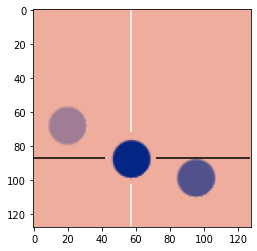

102 : ( 0.78322154 , 0.49190235 )


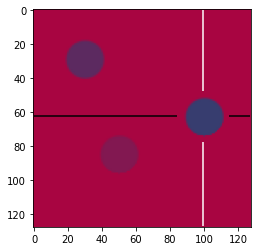

648 : ( 0.4391604 , 0.29098514 )


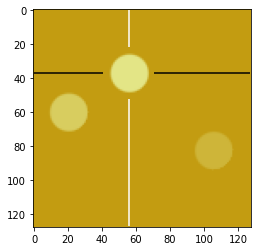

603 : ( 0.80910224 , 0.83507097 )


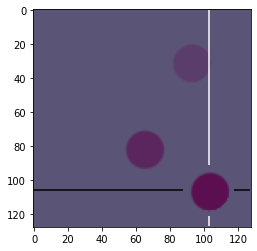

234 : ( 0.17028552 , 0.49625862 )


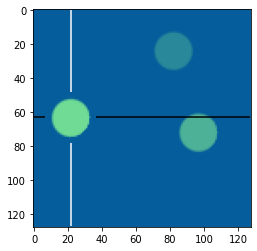

779 : ( 0.30479866 , 0.3153397 )


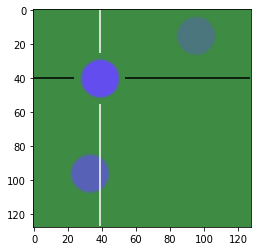

258 : ( 0.79624563 , 0.24958189 )


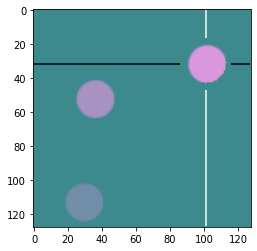

792 : ( 0.48156598 , 0.23990202 )


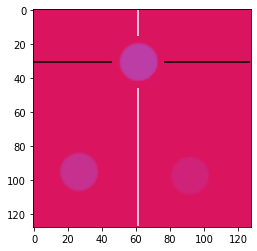

620 : ( 0.33542642 , 0.13730028 )


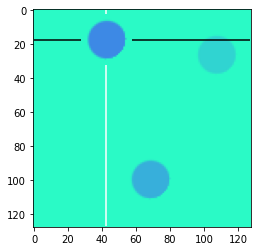

527 : ( 0.47442982 , 0.7491051 )


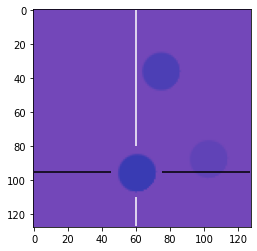

In [ ]:
df.reset_random_seeds()
df.visualize_dataset(images = images_test, labels=labels_test)

# Build and train model

Epoch 1/100
32/32 [==============================] - 5s 128ms/step - loss: 0.7530 - accuracy: 0.5035 - in_disk: 0.0353 - val_loss: 0.0749 - val_accuracy: 0.5140 - val_in_disk: 0.0460
Epoch 2/100
32/32 [==============================] - 4s 117ms/step - loss: 0.0629 - accuracy: 0.5035 - in_disk: 0.0432 - val_loss: 0.0557 - val_accuracy: 0.5140 - val_in_disk: 0.0490
Epoch 3/100
32/32 [==============================] - 4s 117ms/step - loss: 0.0589 - accuracy: 0.5085 - in_disk: 0.0523 - val_loss: 0.0558 - val_accuracy: 0.5140 - val_in_disk: 0.0450
Epoch 4/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0593 - accuracy: 0.4980 - in_disk: 0.0485 - val_loss: 0.0556 - val_accuracy: 0.4860 - val_in_disk: 0.0520
Epoch 5/100
32/32 [==============================] - 4s 117ms/step - loss: 0.0588 - accuracy: 0.4970 - in_disk: 0.0455 - val_loss: 0.0580 - val_accuracy: 0.5140 - val_in_disk: 0.0420
Epoch 6/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0576 - a

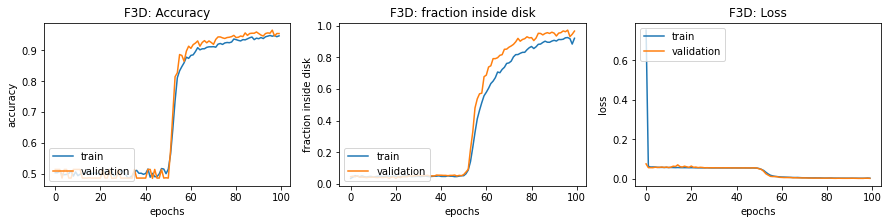

Elapsed time: 376 seconds (6 minutes).
INFO:tensorflow:Assets written to: /content/drive/My Drive/PredatorEye/saved_models/20220110_1218_Find_3_Disks/assets
Saved trained model to /content/drive/My Drive/PredatorEye/saved_models/20220110_1218_Find_3_Disks


In [ ]:
# Run a model.
df.reset_random_seeds()
start_time = time.time()
fcd_model_timestamp = df.timestamp_string()
(model, history) = ([], [])  # To release memory when rerunning in notebook.
gc.collect()

model = df.make_disk_finder_model(images_train)
history = df.run_model(model,
                       images_train, labels_train, images_test, labels_test,
                       epochs=100,
                       batch_size= 128,
                       plot_title='F3D')

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

# model.save(model_save_directory + fcd_model_timestamp)
model_save_path = model_save_directory + fcd_model_timestamp + '_Find_3_Disks'
model.save(model_save_path)
print('Saved trained model to', model_save_path)

# Visualize some predictions

737 : ( 0.45614433 , 0.6938385 )


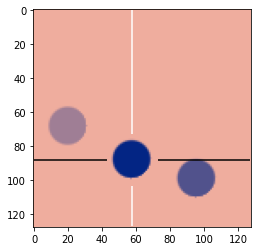

102 : ( 0.8196333 , 0.49659982 )


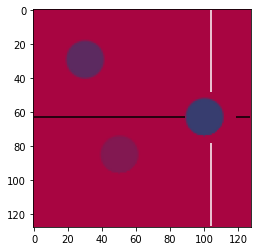

648 : ( 0.40857828 , 0.30839556 )


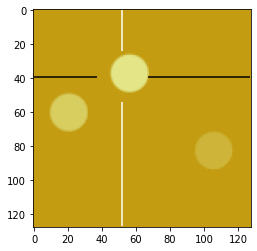

603 : ( 0.7965329 , 0.83473194 )


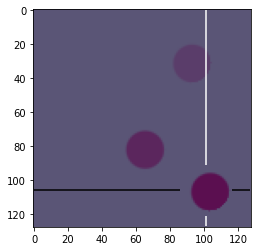

234 : ( 0.1544966 , 0.50033176 )


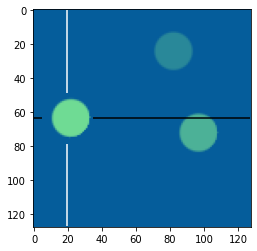

779 : ( 0.29535985 , 0.3393567 )


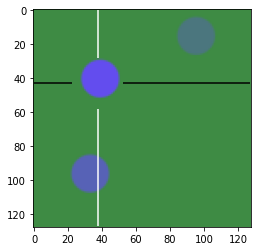

258 : ( 0.7848908 , 0.24167717 )


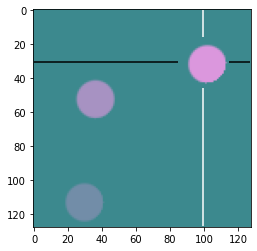

792 : ( 0.46740872 , 0.20172974 )


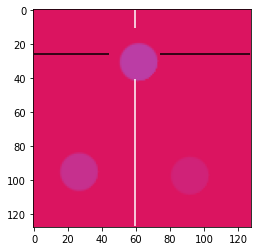

620 : ( 0.3591608 , 0.12900549 )


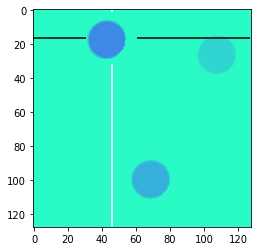

527 : ( 0.4731661 , 0.7822057 )


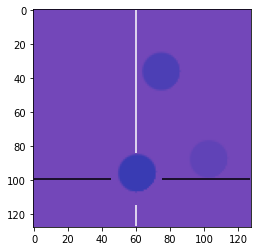

In [ ]:
df.reset_random_seeds()
df.visualize_dataset(images=images_test, model=model)